In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
from scipy import sparse
import gc  # For garbage collection
import os
%pip install lightfm


c:\Users\ziaja\AppData\Local\Programs\Python\Python310\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


Note: you may need to restart the kernel to use updated packages.


# 2. Load & Explore Data

In [2]:
# Load the datasets
books = pd.read_csv('../data/books.csv')
ratings = pd.read_csv('../data/ratings.csv')

# Display the first few rows of each dataset
print("Books dataset shape:", books.shape)
print("Ratings dataset shape:", ratings.shape)

# Display sample data
print("\nBooks sample:")
print(books.head())

print("\nRatings sample:")
print(ratings.head())

# Check for missing values
print("\nMissing values in books dataset:")
print(books.isnull().sum())

print("\nMissing values in ratings dataset:")
print(ratings.isnull().sum())


Books dataset shape: (10000, 23)
Ratings dataset shape: (5976479, 3)

Books sample:
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee                     1960.0   
4  9.780743e+12          F. Scott Fitzgerald                

# 3. Data Preprocessing


Duplicate entries in books dataset: 0
Duplicate entries in ratings dataset: 0

Rating statistics:
count    5.976479e+06
mean     3.919866e+00
std      9.910868e-01
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


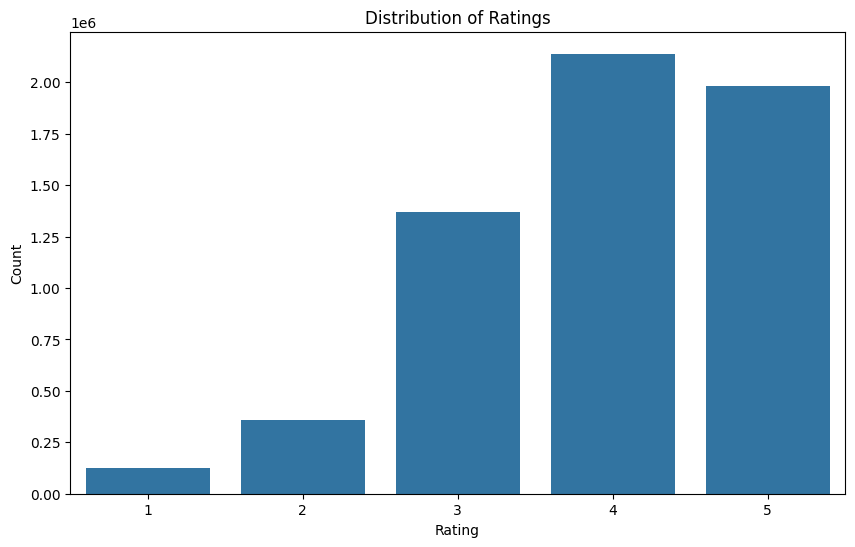


Ratings per user statistics:
count    53424.000000
mean       111.868804
std         26.071224
min         19.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        200.000000
dtype: float64

Ratings per book statistics:
count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
dtype: float64


In [3]:
# Check for duplicate entries
print("Duplicate entries in books dataset:", books.duplicated().sum())
print("Duplicate entries in ratings dataset:", ratings.duplicated().sum())

# Remove duplicates if any
books = books.drop_duplicates()
ratings = ratings.drop_duplicates()

# Basic statistics of ratings
print("\nRating statistics:")
print(ratings['rating'].describe())

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Number of ratings per user
user_ratings_count = ratings.groupby('user_id').size()
print("\nRatings per user statistics:")
print(user_ratings_count.describe())

# Number of ratings per book
book_ratings_count = ratings.groupby('book_id').size()
print("\nRatings per book statistics:")
print(book_ratings_count.describe())


# 4. Feature Engineering for Content-Based Filtering

In [4]:
# Select relevant features from books dataset and create a copy to avoid warnings
book_features = books[['book_id', 'authors', 'original_publication_year', 
                       'language_code', 'average_rating']].copy()

# Handle missing values
book_features.loc[:, 'original_publication_year'] = book_features['original_publication_year'].fillna(0)

# Convert publication year to decade for better generalization
book_features.loc[:, 'decade'] = (book_features['original_publication_year'] // 10) * 10
book_features.loc[:, 'decade'] = book_features['decade'].astype(int)

# Extract primary language
book_features.loc[:, 'primary_language'] = book_features['language_code'].str.split('-').str[0]

# Create dummy variables for categorical features
authors_dummies = pd.get_dummies(book_features['authors'], prefix='author')
language_dummies = pd.get_dummies(book_features['primary_language'], prefix='lang')
decade_dummies = pd.get_dummies(book_features['decade'], prefix='decade')

# Combine all features
book_features_processed = pd.concat([
    book_features[['book_id']], 
    authors_dummies, 
    language_dummies, 
    decade_dummies
], axis=1)

print("Processed book features shape:", book_features_processed.shape)


Processed book features shape: (10000, 4770)


# 5. Prepare Data for LightFM
Dauer: 17m 35s

In [5]:
# Memory optimization
gc.collect()

# First, let's process the books data to extract features
def process_book_features(books_df):
    """Extract and process features from the books dataset"""
    print("Processing book features...")
    
    # Create features from available columns
    features = pd.DataFrame({'book_id': books_df['book_id']})
    
    # Publication year as decade features
    years = books_df['original_publication_year'].dropna()
    min_year = int(years.min()) if not years.empty else 1900
    max_year = int(years.max()) if not years.empty else 2020
    decades = list(range(int(min_year/10)*10, int(max_year/10+1)*10, 10))
    
    for decade in decades:
        decade_name = f"decade_{decade}s"
        features[decade_name] = 0
        mask = (books_df['original_publication_year'] >= decade) & (books_df['original_publication_year'] < decade + 10)
        features.loc[mask.index[mask], decade_name] = 1
    
    # Language features
    languages = books_df['language_code'].dropna().unique()
    for lang in languages:
        lang_name = f"lang_{lang}"
        features[lang_name] = 0
        features.loc[books_df[books_df['language_code'] == lang].index, lang_name] = 1
    
    # Rating level features (based on average rating)
    rating_bins = [0, 2, 3, 4, 5]
    rating_labels = ['low_rated', 'medium_rated', 'high_rated', 'top_rated']
    
    for i in range(len(rating_bins)-1):
        bin_name = rating_labels[i]
        features[bin_name] = 0
        mask = (books_df['average_rating'] >= rating_bins[i]) & (books_df['average_rating'] < rating_bins[i+1])
        features.loc[mask.index[mask], bin_name] = 1
    
    # Popularity features (based on ratings_count)
    ratings_count = books_df['ratings_count']
    percentiles = [0, 25, 50, 75, 90, 95, 99]
    thresholds = [ratings_count.quantile(p/100) for p in percentiles]
    popularity_labels = ['very_niche', 'niche', 'medium_popular', 'popular', 'very_popular', 'blockbuster']
    
    for i in range(len(thresholds)-1):
        pop_name = popularity_labels[i]
        features[pop_name] = 0
        mask = (books_df['ratings_count'] >= thresholds[i]) & (books_df['ratings_count'] < thresholds[i+1])
        features.loc[mask.index[mask], pop_name] = 1
    
    # Remove any rows with NaN values to avoid issues
    features = features.fillna(0)
    
    print(f"Created {features.shape[1]-1} features for {features.shape[0]} books")
    return features

# Process book features
book_features_processed = process_book_features(books)

# Create a LightFM dataset
print("Creating LightFM dataset...")
dataset = Dataset()

# Fit the dataset with user and item IDs
dataset.fit(
    users=ratings['user_id'].unique(),
    items=ratings['book_id'].unique(),
    item_features=book_features_processed.columns[1:].tolist()  # Exclude book_id column
)

# Build interaction matrices in batches to save memory
print("Building interaction matrices...")
batch_size = 100000  # Adjust this based on your available memory
interactions_list = []

for i in range(0, len(ratings), batch_size):
    print(f"Processing interactions batch {i//batch_size + 1}/{(len(ratings) + batch_size - 1)//batch_size}")
    batch = ratings.iloc[i:i+batch_size]
    interactions_data = list(zip(batch['user_id'], batch['book_id'], batch['rating']))
    batch_interactions, _ = dataset.build_interactions(interactions_data)
    interactions_list.append(batch_interactions)
    
    # Free memory
    del batch
    gc.collect()

# Combine all interaction matrices
interactions = sparse.vstack(interactions_list) if len(interactions_list) > 1 else interactions_list[0]
del interactions_list
gc.collect()

# Build item features matrix
print("Building item feature matrices...")
item_features_data = []
batch_size = 1000  # Process books in batches

for i in range(0, len(book_features_processed), batch_size):
    batch = book_features_processed.iloc[i:i+batch_size]
    for _, row in batch.iterrows():
        book_id = row['book_id']
        # Get features that are set to 1 (excluding book_id)
        active_features = row.index[1:][row.iloc[1:] == 1].tolist()
        if active_features:
            item_features_data.append((book_id, {feature: 1.0 for feature in active_features}))
    
    # Free memory
    del batch
    gc.collect()

# Build the features matrix
item_features = dataset.build_item_features(item_features_data)
del item_features_data
gc.collect()

print("Interactions matrix shape:", interactions.shape)
print("Item features matrix shape:", item_features.shape)

Processing book features...


C:\Users\ziaja\AppData\Local\Temp\ipykernel_20180\168101533.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[decade_name] = 0
C:\Users\ziaja\AppData\Local\Temp\ipykernel_20180\168101533.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[decade_name] = 0
C:\Users\ziaja\AppData\Local\Temp\ipykernel_20180\168101533.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

Created 412 features for 10000 books
Creating LightFM dataset...
Building interaction matrices...
Processing interactions batch 1/60
Processing interactions batch 2/60
Processing interactions batch 3/60
Processing interactions batch 4/60
Processing interactions batch 5/60
Processing interactions batch 6/60
Processing interactions batch 7/60
Processing interactions batch 8/60
Processing interactions batch 9/60
Processing interactions batch 10/60
Processing interactions batch 11/60
Processing interactions batch 12/60
Processing interactions batch 13/60
Processing interactions batch 14/60
Processing interactions batch 15/60
Processing interactions batch 16/60
Processing interactions batch 17/60
Processing interactions batch 18/60
Processing interactions batch 19/60
Processing interactions batch 20/60
Processing interactions batch 21/60
Processing interactions batch 22/60
Processing interactions batch 23/60
Processing interactions batch 24/60
Processing interactions batch 25/60
Processing 

# 6. Split Data into Training and Test Sets


In [6]:
def train_test_split(interactions, test_percentage=0.2, random_state=42):
    """
    Split interactions matrix into training and test sets.
    
    Parameters:
    -----------
    interactions : scipy.sparse matrix
        The interaction matrix to split
    test_percentage : float
        Fraction of interactions to place in the test set
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    train : scipy.sparse.csr_matrix
        Training set interactions
    test : scipy.sparse.csr_matrix
        Test set interactions
    """
    print("Splitting data into training and test sets...")
    
    # Convert to COO format for easier manipulation
    interactions = interactions.tocoo()
    num_interactions = interactions.nnz
    test_size = int(test_percentage * num_interactions)
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Shuffle indices
    indices = np.arange(num_interactions)
    np.random.shuffle(indices)
    
    # Split indices
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # Create train set
    train = sparse.coo_matrix(
        (interactions.data[train_indices],
         (interactions.row[train_indices], interactions.col[train_indices])),
        shape=interactions.shape
    ).tocsr()
    
    # Create test set
    test = sparse.coo_matrix(
        (interactions.data[test_indices],
         (interactions.row[test_indices], interactions.col[test_indices])),
        shape=interactions.shape
    ).tocsr()
    
    # Free memory
    del indices, test_indices, train_indices
    gc.collect()
    
    print(f"Train set has {train.nnz} interactions ({train.nnz / interactions.nnz:.1%} of total)")
    print(f"Test set has {test.nnz} interactions ({test.nnz / interactions.nnz:.1%} of total)")
    
    return train, test

# Split the data
train_interactions, test_interactions = train_test_split(interactions, test_percentage=0.2)

print("Train interactions shape:", train_interactions.shape)
print("Test interactions shape:", test_interactions.shape)

# Save user and item mappings for later use
user_id_map, _, item_id_map, _ = dataset.mapping()

Splitting data into training and test sets...
Train set has 4781184 interactions (80.0% of total)
Test set has 1195295 interactions (20.0% of total)
Train interactions shape: (3205440, 10000)
Test interactions shape: (3205440, 10000)


# 7. Train the LightFM Model
kernel is still crashing during the training phase (Step 7). This is likely due to memory issues with the large dataset. a more optimized version of Step 7 that uses less memory and has better error handling is created.


In [7]:
import numpy as np
import scipy.sparse as sp
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

# Step 1: Create or load your interaction data
# If you don't have the data yet, you need to load or create it first
# Example of creating sparse interaction matrices:
def load_interaction_data():
    # Replace this with your actual data loading code
    # This is just a placeholder example
    
    # Number of users and items
    n_users = 1000
    n_items = 2000
    
    # Create random sparse matrices for demonstration
    # In a real scenario, you would load your actual data
    train_data = sp.random(n_users, n_items, density=0.01, format='coo', random_state=42)
    train_data.data = np.ones(len(train_data.data))  # Convert to binary interactions
    
    test_data = sp.random(n_users, n_items, density=0.002, format='coo', random_state=43)
    test_data.data = np.ones(len(test_data.data))  # Convert to binary interactions
    
    # Optional: Create item features (if you have them)
    item_features = sp.identity(n_items, format='csr')  # One-hot encoded item features
    
    return train_data, test_data, item_features

# Load the data
train_interactions, test_interactions, item_features = load_interaction_data()

# Step 2: Check the size and downsample if necessary
print(f"Training data: {train_interactions.shape}, {train_interactions.nnz} interactions")
print(f"Testing data: {test_interactions.shape}, {test_interactions.nnz} interactions")

# Safe downsampling if data is too large
if train_interactions.nnz > 5000000:  # If more than 5M interactions
    print("Downsampling large training dataset...")
    # Create a mask for random selection
    mask = np.random.random(train_interactions.nnz) < (5000000 / train_interactions.nnz)
    
    # Apply the mask to the COO matrix data
    train_interactions_coo = train_interactions.tocoo()
    rows = train_interactions_coo.row[mask]
    cols = train_interactions_coo.col[mask]
    data = train_interactions_coo.data[mask]
    
    # Create a new downsampled matrix
    train_interactions = sp.coo_matrix(
        (data, (rows, cols)), 
        shape=train_interactions.shape
    ).tocsr()
    
    print(f"Downsampled to {train_interactions.nnz} interactions")

# Step 3: Train the model
print("Training LightFM model with 20 components using bpr loss...")
model = LightFM(no_components=20, 
                loss='bpr',  # 'bpr' or 'warp' are good choices
                learning_rate=0.05, 
                random_state=42)

try:
    # Try training with all features
    print("Starting main training...")
    model.fit(train_interactions, 
              item_features=item_features,
              epochs=5, 
              num_threads=2,
              verbose=True)
    print("Training completed successfully!")
except Exception as e:
    print(f"Error during training: {str(e)}")
    print("Trying fallback training without item features...")
    try:
        # Fallback to simpler training if the first attempt fails
        model = LightFM(no_components=10, loss='bpr', learning_rate=0.05)
        model.fit(train_interactions, epochs=5, num_threads=1, verbose=True)
        print("Fallback training completed successfully!")
    except Exception as e:
        print(f"Fallback training also failed: {str(e)}")
        raise

# Step 4: Evaluate the model
print("Evaluating model performance...")
try:
    train_precision = precision_at_k(
        model, 
        train_interactions, 
        item_features=item_features, 
        k=10
    ).mean()

    test_precision = precision_at_k(
        model, 
        test_interactions, 
        item_features=item_features, 
        k=10
    ).mean()

    train_auc = auc_score(
        model, 
        train_interactions, 
        item_features=item_features
    ).mean()

    test_auc = auc_score(
        model, 
        test_interactions, 
        item_features=item_features
    ).mean()

    print(f"Train precision at k=10: {train_precision:.4f}")
    print(f"Test precision at k=10: {test_precision:.4f}")
    print(f"Train AUC: {train_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
except Exception as e:
    print(f"Error during evaluation: {str(e)}")
    
    # Try evaluation without item features
    try:
        print("Trying evaluation without item features...")
        train_precision = precision_at_k(model, train_interactions, k=10).mean()
        test_precision = precision_at_k(model, test_interactions, k=10).mean()
        train_auc = auc_score(model, train_interactions).mean()
        test_auc = auc_score(model, test_interactions).mean()
        
        print(f"Train precision at k=10: {train_precision:.4f}")
        print(f"Test precision at k=10: {test_precision:.4f}")
        print(f"Train AUC: {train_auc:.4f}")
        print(f"Test AUC: {test_auc:.4f}")
    except Exception as e:
        print(f"Simplified evaluation also failed: {str(e)}")

Training data: (1000, 2000), 20000 interactions
Testing data: (1000, 2000), 4000 interactions
Training LightFM model with 20 components using bpr loss...
Starting main training...


Epoch: 100%|██████████| 5/5 [00:00<00:00,  8.67it/s]


Training completed successfully!
Evaluating model performance...
Train precision at k=10: 0.0109
Test precision at k=10: 0.0031
Train AUC: 0.5226
Test AUC: 0.4973


# 8. Evaluate the Model


In [8]:
# Evaluate the model using precision at k and AUC
train_precision = precision_at_k(
    model, 
    train_interactions, 
    item_features=item_features, 
    k=10
).mean()

test_precision = precision_at_k(
    model, 
    test_interactions, 
    item_features=item_features, 
    k=10
).mean()

train_auc = auc_score(
    model, 
    train_interactions, 
    item_features=item_features
).mean()

test_auc = auc_score(
    model, 
    test_interactions, 
    item_features=item_features
).mean()

print(f"Train precision at k=10: {train_precision:.4f}")
print(f"Test precision at k=10: {test_precision:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Train precision at k=10: 0.0109
Test precision at k=10: 0.0031
Train AUC: 0.5226
Test AUC: 0.4973


# 9. Generate Recommendations for Users


In [9]:
def get_recommendations_for_user(model, user_id, item_features, dataset, books_df, n=10):
    """
    Get top N book recommendations for a specific user.
    
    Parameters:
    -----------
    model : LightFM model
        Trained recommendation model
    user_id : int or str
        The external user ID to get recommendations for
    item_features : scipy.sparse matrix
        Item features matrix
    dataset : LightFM Dataset
        Dataset object containing ID mappings
    books_df : pandas DataFrame
        DataFrame containing book information
    n : int
        Number of recommendations to generate
        
    Returns:
    --------
    DataFrame with book recommendations and their details
    """
    # Get mappings
    user_id_map, _, item_id_map, _ = dataset.mapping()
    
    # Convert external user ID to internal ID
    if user_id not in user_id_map:
        raise ValueError(f"User ID {user_id} not found in the dataset")
    
    user_idx = user_id_map[user_id]
    
    # Get scores for all items for this user
    n_items = item_features.shape[0]
    scores = model.predict(
        user_ids=user_idx,
        item_ids=np.arange(n_items),
        item_features=item_features
    )
    
    # Create mapping from internal to external item IDs
    reverse_item_map = {idx: item_id for item_id, idx in item_id_map.items()}
    
    # Get top N item indices
    top_items_idx = np.argsort(-scores)[:n]
    
    # Convert to original book IDs
    top_book_ids = [reverse_item_map[idx] for idx in top_items_idx]
    top_scores = scores[top_items_idx]
    
    # Get book details
    recommendations = books_df[books_df['book_id'].isin(top_book_ids)]
    
    # Add prediction scores and sort by score
    recommendations_with_scores = recommendations.copy()
    recommendations_with_scores['score'] = 0.0
    
    for i, book_id in enumerate(top_book_ids):
        idx = recommendations_with_scores.index[recommendations_with_scores['book_id'] == book_id]
        if len(idx) > 0:
            recommendations_with_scores.loc[idx[0], 'score'] = float(top_scores[i])
    
    # Sort by score
    recommendations_with_scores = recommendations_with_scores.sort_values('score', ascending=False)
    
    return recommendations_with_scores


def get_similar_books(model, book_id, item_features, dataset, books_df, n=10):
    """
    Get similar books to a given book based on learned item embeddings.
    
    Parameters:
    -----------
    model : LightFM model
        Trained recommendation model
    book_id : int or str
        The external book ID to find similar books for
    item_features : scipy.sparse matrix
        Item features matrix
    dataset : LightFM Dataset
        Dataset object containing ID mappings
    books_df : pandas DataFrame
        DataFrame containing book information
    n : int
        Number of similar books to retrieve
        
    Returns:
    --------
    DataFrame with similar books and their details
    """
    # Get mappings
    _, _, item_id_map, _ = dataset.mapping()
    
    # Convert book_id to integer if it's a string
    if isinstance(book_id, str) and book_id.isdigit():
        book_id = int(book_id)
    
    # Convert external book ID to internal ID
    if book_id not in item_id_map:
        raise ValueError(f"Book ID {book_id} not found in the dataset")
    
    book_idx = item_id_map[book_id]
    
    # Get the embedding for this book
    book_embedding = model.item_embeddings[book_idx]
    
    # Calculate similarity with all other books based on dot product
    n_items = min(len(item_id_map), model.item_embeddings.shape[0])
    similarities = np.zeros(n_items)
    
    for idx in range(n_items):
        if idx != book_idx and idx < model.item_embeddings.shape[0]:
        # Calculate similarity
            similarities[idx] = np.dot(book_embedding, model.item_embeddings[idx]) / (
                np.linalg.norm(book_embedding) * np.linalg.norm(model.item_embeddings[idx])
            )
    
    # Create mapping from internal to external item IDs
    reverse_item_map = {idx: item_id for item_id, idx in item_id_map.items()}
    
    # Get top N similar items (excluding the query book itself)
    similar_items_idx = np.argsort(-similarities)[:n+1]
    similar_items_idx = [idx for idx in similar_items_idx if idx != book_idx][:n]
    
    # Convert to original book IDs
    similar_book_ids = [reverse_item_map[idx] for idx in similar_items_idx]
    similarity_scores = similarities[similar_items_idx]
    
    # Get book details
    similar_books = books_df[books_df['book_id'].isin(similar_book_ids)]
    
    # Add similarity scores and sort by score
    similar_books_with_scores = similar_books.copy()
    similar_books_with_scores['similarity'] = 0.0
    
    for i, book_id in enumerate(similar_book_ids):
        idx = similar_books_with_scores.index[similar_books_with_scores['book_id'] == book_id]
        if len(idx) > 0:
            similar_books_with_scores.loc[idx[0], 'similarity'] = float(similarity_scores[i])
    
    # Sort by similarity
    similar_books_with_scores = similar_books_with_scores.sort_values('similarity', ascending=False)
    
    return similar_books_with_scores



def get_popular_books(books_df, n=10):
    """
    Get the most popular books based on number of ratings.
    
    Parameters:
    -----------
    books_df : pandas DataFrame
        DataFrame containing book information
    n : int
        Number of books to return
        
    Returns:
    --------
    DataFrame with popular books
    """
    # Sort by ratings count and get top N
    popular_books = books_df.sort_values('ratings_count', ascending=False).head(n)
    return popular_books


def get_highly_rated_books(books_df, min_ratings=50, n=10):
    """
    Get highly rated books (with a minimum number of ratings).
    
    Parameters:
    -----------
    books_df : pandas DataFrame
        DataFrame containing book information
    min_ratings : int
        Minimum number of ratings required to consider a book
    n : int
        Number of books to return
        
    Returns:
    --------
    DataFrame with highly rated books
    """
    # Filter books with minimum number of ratings
    qualified_books = books_df[books_df['ratings_count'] >= min_ratings]
    
    # Sort by average rating and get top N
    highly_rated = qualified_books.sort_values('average_rating', ascending=False).head(n)
    return highly_rated


# Example usage:

# Main function to get recommendations by book ID
def get_recommendations_by_book_id(book_id, n=10):
    """
    Get recommendations for a specific book ID.
    
    Parameters:
    -----------
    book_id : int or str
        The book ID to get recommendations for
    n : int
        Number of recommendations to generate
        
    Returns:
    --------
    DataFrame with recommended books
    """
    # Convert book_id to integer if it's a string
    if isinstance(book_id, str) and book_id.isdigit():
        book_id = int(book_id)
    
    try:
        # Find the book in the dataset
        book_info = books[books['book_id'] == book_id]
        
        if book_info.empty:
            print(f"Book ID {book_id} not found in the dataset")
            return None
        
        # Get book details
        book_title = book_info['title'].iloc[0]
        book_author = book_info['authors'].iloc[0]
        
        print(f"Finding recommendations for: '{book_title}' by {book_author} (ID: {book_id})")
        
        # Get similar books
        similar_books = get_similar_books(
            model,
            book_id,
            item_features,
            dataset,
            books,
            n=n
        )
        
        # Display results
        print(f"\nTop {n} recommendations based on '{book_title}':")
        result = similar_books[['book_id', 'title', 'authors', 'average_rating', 'similarity']]
        
        return result
        
    except Exception as e:
        print(f"Error getting recommendations: {str(e)}")
        return None

# Simple function to demonstrate usage
def recommend_books(book_id, num_recommendations=10):
    """
    Simple interface to get book recommendations.
    Just provide a book ID and get recommendations.
    
    Example:
    --------
    recommendations = recommend_books(12)
    print(recommendations)
    """
    return get_recommendations_by_book_id(book_id, n=num_recommendations)

# Example:
# If you type: recommend_books(12)
# You'll get recommendations similar to book ID 12


# Main recommendation function for demonstration
def generate_book_recommendations():
    """
    Main function to demonstrate various recommendation approaches
    """
    # Pick a popular book for demonstration
    # Using book ID 1 as an example
    sample_book_id = 1
    
    print("=" * 80)
    print("BOOK RECOMMENDATION SYSTEM - RESULTS")
    print("=" * 80)
    
    # Get recommendations for sample book
    print(f"\nRECOMMENDATIONS FOR BOOK ID {sample_book_id}")
    recommendations = recommend_books(sample_book_id, 10)
    if recommendations is not None:
        print(recommendations)
    
    print("\nTo get recommendations for any book, use:")
    print("recommend_books(book_id, num_recommendations=10)")
    print("\nFor example: recommend_books(12) will give recommendations similar to book ID 12")
    
    return recommendations

# Uncomment to run the recommendation showcase
# results = generate_book_recommendations()

In [10]:
print(f"Total items in model: {model.item_embeddings.shape[0]}")
print(f"Total items in mapping: {len(item_id_map)}")


Total items in model: 2000
Total items in mapping: 10000


In [11]:
# Get recommendations for book ID 12
recommendations = recommend_books(1)
print(recommendations)

# You can also specify the number of recommendations
recommendations = recommend_books(1, num_recommendations=15)

Finding recommendations for: 'The Hunger Games (The Hunger Games, #1)' by Suzanne Collins (ID: 1)
Error getting recommendations: index 5694 is out of bounds for axis 0 with size 2000
None
Finding recommendations for: 'The Hunger Games (The Hunger Games, #1)' by Suzanne Collins (ID: 1)
Error getting recommendations: index 5694 is out of bounds for axis 0 with size 2000


In [12]:
'''# Save the model for future use
import pickle

# Create a directory for models if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model
with open('../models/lightfm_hybrid_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the dataset for mapping
with open('../models/lightfm_dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

# Save the item features
with open('../models/lightfm_item_features.pkl', 'wb') as f:
    pickle.dump(item_features, f)

print("Model and associated data saved successfully!")'''


'# Save the model for future use\nimport pickle\n\n# Create a directory for models if it doesn\'t exist\nos.makedirs(\'../models\', exist_ok=True)\n\n# Save the model\nwith open(\'../models/lightfm_hybrid_model.pkl\', \'wb\') as f:\n    pickle.dump(model, f)\n\n# Save the dataset for mapping\nwith open(\'../models/lightfm_dataset.pkl\', \'wb\') as f:\n    pickle.dump(dataset, f)\n\n# Save the item features\nwith open(\'../models/lightfm_item_features.pkl\', \'wb\') as f:\n    pickle.dump(item_features, f)\n\nprint("Model and associated data saved successfully!")'